Name: Bilal Suleman

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from IPython import display
import pandas as pd
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
!ls horses

images masks


In [5]:

## helper funciton for loading the horses data
#make sure the horses data is in the same directory as the notebook
#do not change this function
def load_horses_orig(path, image_size):
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):

        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)

        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0


        images.append(low_im)
        masks.append(bin_mask)


    xtest = np.reshape(np.array(images[250:]), (-1,image_size*image_size*3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size * image_size))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size*image_size*3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size * image_size))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size * image_size))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size*image_size*3))


    return xdata, xval, xtest, ydata, yval, ytest


In [7]:
#change the path address if put the data somewhere else
path = 'horses/'
image_size = 32;
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

In [8]:
#helper function to drawing horse and its mask
def draw(image, mask):
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(np.reshape(image, (image_size,image_size,3)))
    ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
    plt.show()

The task is to predict the mask for the horse given the image
Mask is binary image shows the presence of the horse.

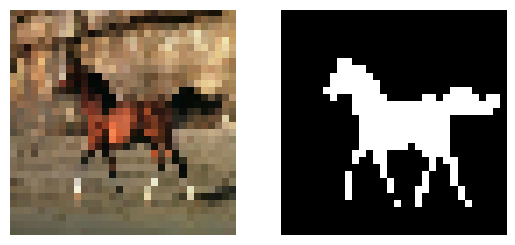

In [9]:
 draw(xdata[0], ydata[0])

In [12]:
train_size = xdata.shape[0]
batch_size = 10
train_dataset = (tf.data.Dataset.from_tensor_slices(np.hstack((xdata, ydata)))
                 .shuffle(train_size).batch(batch_size))

The intersection over union (IOU) is a metric for measuring the performance of image segmentation. The perfect segmentation receives IOU of one.

In [13]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    return np.average(intersect / (union+0.0))


In [14]:
assert iou(ydata, ydata) == 1.0

We can use feedforwad MLP or CNN  model for image segmentation. Here the input is the image and the output is the segmentation mask.

In [55]:
class NeuralNet(tf.keras.Model):

    def construct_CNN(self):
        # COMPLETE ME
        # The following code is a function to construct the CNN model.
        # This is accomplished by passing the data through convolution layers with the first layer having 32 filters and the next having 64.
        # Dropouts and BatchNormalization are also used to curb overfitting and finally the model is flattened and adjusted with Dense layers.
        
        self.model = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(image_size, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling2D((2, 2)),
                tf.keras.layers.Dropout(0.5),

                tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPooling2D((2, 2)),
                tf.keras.layers.Dropout(0.5),

                # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                # # tf.keras.layers.BatchNormalization(),
                # tf.keras.layers.MaxPooling2D((2, 2)),
                # tf.keras.layers.Dropout(0.4),

                # tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                # tf.keras.layers.MaxPooling2D((2, 2)),
                # tf.keras.layers.Dropout(0.4),

                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
        pass


    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )


    def __init__(self, network_type = 'MLP'):
        super(NeuralNet, self).__init__()
        #DOCUMENT ME
        # SGD is the simplest optimizer that updates the weights in the direction opposite to the gradient of the loss function with 
        # respect to the weights. It uses a constant learning rate.
        # self.optimizer = tf.keras.optimizers.SGD(0.1)
        # Adam (Adaptive Moment Estimation) combines ideas from RMSprop and Momentum. 
        # It adapts the learning rates of each parameter individually, allowing for faster convergence and better 
        # handling of sparse gradients.
        # self.optimizer = tf.keras.optimizers.legacy.Adam(0.0001)
        #What are the other available optimizers
        #Test your code with different optimizers
        
        # RMSprop (Root Mean Squared Propagation) is an adaptive learning rate method that divides the learning rate by the 
        # moving average of the squared gradients. It helps in adapting to the geometry of the loss surface.
        
        self.optimizer = tf.keras.optimizers.legacy.RMSprop(0.0001)


        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();


    #DOCUMENT ME
    # The following function is the forward step of the neural network.
    # This step feeds the data from the neurons through the next layer.
    # The weights and biases will be applied to the data and fed through the neural net so the neurons can produce an output.
    # In our partcular case if the predict flag is true then we apply the sigmoid function to the model and then return it.
    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)

    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);

        #DOCUMENT ME
        # Here in the get_loss function we apply the sigmoid cross entropy loss which calculates just that for our model
        # This is calculated in the function using the given logits and then applied in the sigmoid cross entropy loss formula.
        # That cross entropy loss is then applied to the model using the reduce_sum function which computes the sum of the elements
        # across a tensor.
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);


        return tf.reduce_sum(cross_ent)


    def train_step(self, xbatch,ybatch):

        #DOCUMENT ME
        # The gradient tape function computes the derivative of the loss that we calculate with the get_loss function.
        # We could also stack gradient tapes should we need to calculate higher dimension derivatives however that is not needed
        # in our example.
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)

        #DOCUMENT ME
        # Here the gradient from the gradient tape is actually calculated with the loss as the x variable and all the trainable variables
        # from our model as the y values.
        gradients = tape.gradient(loss, model.trainable_variables)

        #DOCUMENT ME
        # The gradients are then applied here which is essentially calculating and applying those weights and biases
        # and the model is adjusted accourdingly by adding those adjustments in the reduce_sum function.
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [56]:
model = NeuralNet('CNN')
# model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [58]:
#Adopt similar training loop for other problems

max_epoch = 5000

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);

    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");


    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))



    epoch += 1


Epoch 87, Loss: 9.2e+02, IOU - Train: 0.999 Valid: 0.578 Test: 0.603
Epoch 88, Loss: 4.93e+02, IOU - Train: 0.998 Valid: 0.57 Test: 0.603
Epoch 89, Loss: 7.83e+02, IOU - Train: 0.999 Valid: 0.576 Test: 0.603
Epoch 90, Loss: 4.19e+02, IOU - Train: 0.998 Valid: 0.575 Test: 0.603
Epoch 91, Loss: 8.03e+02, IOU - Train: 0.999 Valid: 0.576 Test: 0.603
Epoch 92, Loss: 3.71e+02, IOU - Train: 0.999 Valid: 0.573 Test: 0.603
Epoch 93, Loss: 5.39e+02, IOU - Train: 0.999 Valid: 0.579 Test: 0.603
Epoch 94, Loss: 4.88e+02, IOU - Train: 0.999 Valid: 0.578 Test: 0.603
Epoch 95, Loss: 3.67e+02, IOU - Train: 0.996 Valid: 0.567 Test: 0.603
Epoch 96, Loss: 4.77e+02, IOU - Train: 0.997 Valid: 0.569 Test: 0.603
Epoch 97, Loss: 4.94e+02, IOU - Train: 0.996 Valid: 0.585 Test: 0.604
Epoch 98, Loss: 3.49e+02, IOU - Train: 0.999 Valid: 0.578 Test: 0.604
Epoch 99, Loss: 3.29e+02, IOU - Train: 0.999 Valid: 0.576 Test: 0.604
Epoch 100, Loss: 4.52e+02, IOU - Train: 0.999 Valid: 0.573 Test: 0.604
Epoch 101, Loss: 3.57

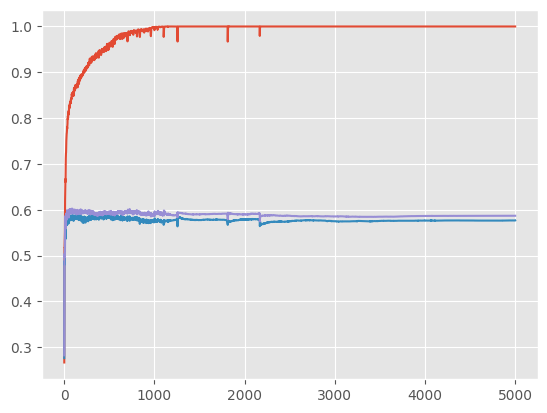

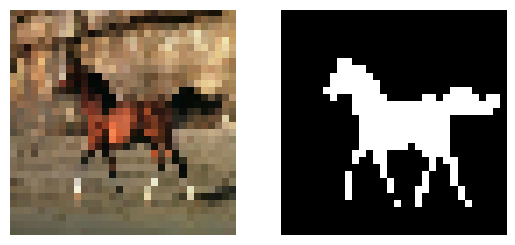

In [43]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [59]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

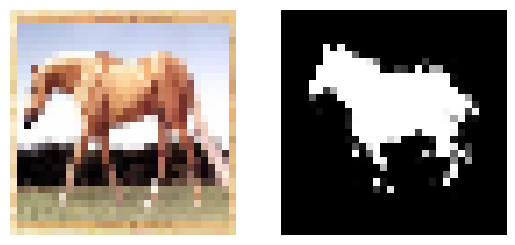

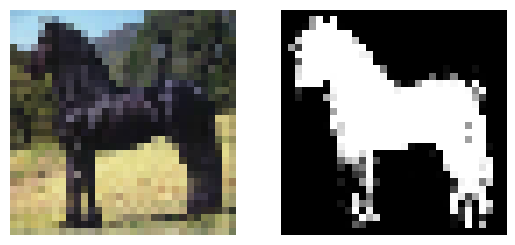

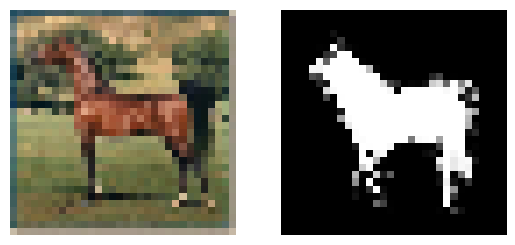

In [60]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [61]:
iou(ytest, ypred)

0.6084324036689871

In [62]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]